In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from torchvision import transforms, models
import torch.nn as nn

from tqdm.notebook import tqdm
import os
import shutil 

import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# распаковываем train (train_cls + val_cls)
!unzip "/content/drive/MyDrive/train_val_cls.zip" -d "/content"

In [ ]:
train_dir = 'train_cls'
val_dir = 'val_cls'

### Разбиваем данные

In [5]:
class_names = ['ER', 'NR']
data_root = '/content/'
for dir_name in ['train']:
    for class_name in class_names:
        os.makedirs(os.path.join(data_root, dir_name, class_name), exist_ok=True)

In [7]:
for class_name in class_names:
  for mode in ['train_cls', 'val_cls']:
    source_dir = os.path.join(data_root, mode, class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(data_root, 'train', class_name, file_name))

### Создаем загрузчики

In [8]:
train_dir = 'train'
val_dir = 'val_cls'

In [9]:

train_transforms = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
len(train_dataloader), len(train_dataset)

(838, 13404)

### Обучение моделей

In [11]:
SEED = 192
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [12]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    hystory_loss_train = []
    hystory_loss_val = []

    hystory_acc_train = []
    hystory_acc_val = []  
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
              hystory_loss_train.append(epoch_loss)
              hystory_acc_train.append(epoch_acc)
            else:
              hystory_loss_val.append(epoch_loss)
              hystory_acc_val.append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val

 ### Модель v1 (c LeakyReLU)

In [32]:
class Net_v1(nn.Module):
    def __init__(self):
      super(Net_v1, self).__init__()
      self.c1 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
          nn.BatchNorm2d(16),
          nn.LeakyReLU()
          
      )

      self.c2 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
          nn.Dropout2d(p=0.3),
          nn.BatchNorm2d(32),
          nn.MaxPool2d(kernel_size=3),
          nn.LeakyReLU()   
      )

      self.c3 = nn.Sequential(
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
          nn.Dropout2d(p=0.3),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(kernel_size=3),
          nn.LeakyReLU()
         
      )

      self.c4 = nn.Sequential(
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
          nn.BatchNorm2d(128),
          nn.MaxPool2d(kernel_size=3),
          nn.LeakyReLU(),
          
      )

      self.fc1 = nn.Sequential(
          nn.Linear(in_features=2048, out_features=1024),
          nn.LeakyReLU()
      )

      self.fc2 = nn.Sequential(
          nn.Linear(in_features=1024, out_features=32),
          nn.LeakyReLU()
      )

      self.fc3 = nn.Linear(in_features=32, out_features=2)
      
    def forward(self, x):
      x = self.c1(x)
      x = self.c2(x)
      x = self.c3(x)
      x = self.c4(x)
      x = x.view(x.size(0), -1)
      #print(x.shape)
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)
      return x

In [ ]:
# nn.LeakyReLU()
%%time 
device = torch.device("cuda")
net_v1 = Net_v1()
net_v1 = net_v1.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(net_v1.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val =\
train_model(net_v1, loss, optimizer, scheduler, 50);

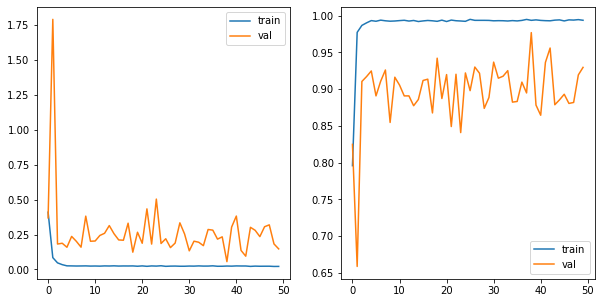

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(hystory_loss_train, label='train')
ax1.plot(hystory_loss_val, label='val')
ax1.legend()

ax2.plot(hystory_acc_train, label='train')
ax2.plot(hystory_acc_val, label='val')
ax2.legend()

### Модель v2 (SkipConnection)

In [13]:
class Net_v2(nn.Module):
    def __init__(self):
      super(Net_v2, self).__init__()
      self.c1 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(3),
          nn.ReLU(), 
      )

      self.c2 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(3),
          nn.ReLU(),  
      )

      self.c3 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
          nn.BatchNorm2d(16),
          nn.MaxPool2d(kernel_size=3),
          nn.ReLU(),
         
      )

      self.c4 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
          nn.BatchNorm2d(32),
          nn.MaxPool2d(kernel_size=3),
          nn.ReLU(),
          
      )

      self.fc1 = nn.Sequential(
          nn.Linear(in_features=7200, out_features=1024),
          nn.ReLU()
      )

      self.fc2 = nn.Sequential(
          nn.Linear(in_features=1024, out_features=32),
          nn.ReLU()
      )

      self.fc3 = nn.Linear(in_features=32, out_features=2)
      
    def forward(self, x):
      # First block
      residual_1 = x
      out = self.c1(x)
      out += residual_1
      #print(out.shape)

      # Second block
      residual_2 = out
      out = self.c2(x)
      out += residual_2
      
      out = self.c3(out)
      out = self.c4(out)

      out = out.view(out.size(0), -1)
      #print(out.shape)
      out = self.fc1(out)
      out = self.fc2(out)
      out = self.fc3(out)
      return out

In [14]:
%%time
device = torch.device("cuda")
net_v2 = Net_v2()
net_v2 = net_v2.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(net_v2.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val =\
train_model(net_v2, loss, optimizer, scheduler, 10);

Epoch 0/9:


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



train Loss: 0.3855 Acc: 0.8176



val Loss: 0.1229 Acc: 0.9886
Epoch 1/9:



train Loss: 0.0704 Acc: 0.9874



val Loss: 0.0394 Acc: 0.9958
Epoch 2/9:



train Loss: 0.0334 Acc: 0.9941



val Loss: 0.0231 Acc: 0.9949
Epoch 3/9:



train Loss: 0.0237 Acc: 0.9948



val Loss: 0.0322 Acc: 0.9893
Epoch 4/9:



train Loss: 0.0185 Acc: 0.9960



val Loss: 0.0150 Acc: 0.9976
Epoch 5/9:



train Loss: 0.0177 Acc: 0.9963



val Loss: 0.0153 Acc: 0.9980
Epoch 6/9:



train Loss: 0.0174 Acc: 0.9969



val Loss: 0.0147 Acc: 0.9980
Epoch 7/9:



train Loss: 0.0182 Acc: 0.9959



val Loss: 0.0142 Acc: 0.9980
Epoch 8/9:



train Loss: 0.0172 Acc: 0.9969



val Loss: 0.0151 Acc: 0.9976
Epoch 9/9:



train Loss: 0.0174 Acc: 0.9962



val Loss: 0.0140 Acc: 0.9980
CPU times: user 1min 40s, sys: 35.8 s, total: 2min 15s
Wall time: 9min 41s


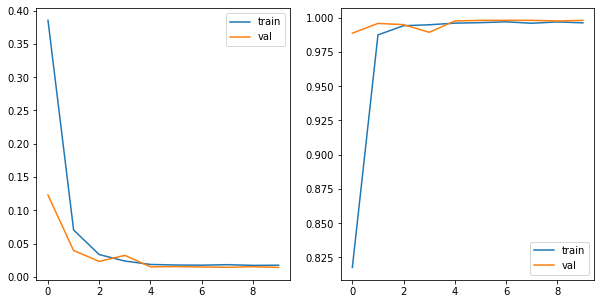

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(hystory_loss_train, label='train')
ax1.plot(hystory_loss_val, label='val')
ax1.legend()

# валидация не показательна
ax2.plot(hystory_acc_train, label='train')
ax2.plot(hystory_acc_val, label='val')
ax2.legend()

In [16]:
torch.save(net_v2, '/content/drive/MyDrive/skipconnection_er_nr.pt')

### Предсказание на тесте и submission

In [17]:
from collections import defaultdict

In [ ]:
# распаковываем test_public
!unzip "/content/drive/MyDrive/public_test.zip" -d "/content/test"

# распаковываем test_private
!unzip "/content/drive/MyDrive/private_test.zip" -d "/content/test"

In [19]:
test_transforms = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [21]:
test_dir = 'test'
test_dataset = torchvision.datasets.ImageFolder(test_dir, test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=16)
len(test_loader), len(test_dataset)

(1035, 16560)

In [22]:
dict_pred = defaultdict(list)
file_names = []
for line in test_dataset.imgs:
  file_names.append(str(line).split('/')[-1].split('.')[0])

dict_pred["id"] = file_names

In [23]:
%%time
net_v2.to('cuda').eval()
with torch.no_grad():
    for i, (img, name) in enumerate(tqdm(test_loader)):
        img = img.to('cuda')
        outputs = net_v2(img)
        _, predicted = torch.max(outputs.data, dim=1)
        predicted = list(map(int, predicted.cpu()))
        dict_pred["classification_predictions"].extend(predicted)


CPU times: user 1min, sys: 3.66 s, total: 1min 4s
Wall time: 1min 14s


In [24]:
data_frame = pd.DataFrame(dict_pred, columns=["id", "classification_predictions"])
data_frame['classification_predictions'] = data_frame.classification_predictions.replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame.head()

,id,classification_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,1
1,0005564c011259402dcb6e3beb6e64d285124fa0,1
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,0
3,000804a189f630cd980ff1543c0ef99d48cd6b34,0
4,000eb12def5371089743dcfe401a8e399f5883fc,0


In [25]:
data_root = '/content/drive/MyDrive/'
data_frame.to_csv(data_root + 'cls_v3.csv', index=False, header=True)

In [26]:
data_frame.shape

(16560, 2)

####  Объеденяем регрессию и классификация в один submission

In [27]:
data_root = '/content/drive/MyDrive/'
cls = pd.read_csv(data_root + 'cls_v3.csv')
reg = pd.read_csv(data_root + 'reg_v3.csv')

In [28]:
cls['regression_predictions'] = reg['regression_predictions']
cls.head()

,id,classification_predictions,regression_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,1,10.0
1,0005564c011259402dcb6e3beb6e64d285124fa0,1,30.0
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,0,20.0
3,000804a189f630cd980ff1543c0ef99d48cd6b34,0,1.0
4,000eb12def5371089743dcfe401a8e399f5883fc,0,20.0


In [29]:
cls.to_csv(data_root + 'skipconnection_v2.csv', index=False, header=True)